In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_load = torch.utils.data.DataLoader(train_set, batch_size = 20, shuffle = True, num_workers = 2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_load = torch.utils.data.DataLoader(test_set, batch_size = 20, shuffle = False, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


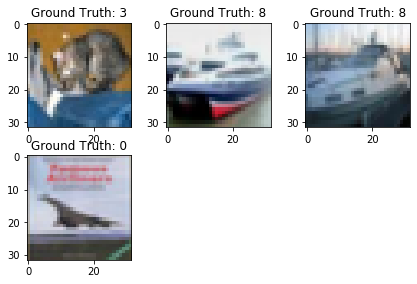

In [3]:
dataiter = enumerate(test_load)
idx, (data, truth) = next(dataiter)

fig = plt.figure()
for i in range(0,4):
    img = torchvision.utils.make_grid(data[i])
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.subplot(2,3, i+1)
    plt.tight_layout()
    plt.imshow(np.transpose(npimg,(1,2,0))) 
    plt.title("Ground Truth: {}".format(truth[i]))
plt.show()

In [4]:
class NN(nn.Module):

    def __init__(self):
        super(NN, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5) # 1st convolution: 3 input channels for the images to come into, 6 filters each 5x5 pxls to produce outputs.
        self.conv2 = nn.Conv2d(6, 16, 5) # 2nd convolution: 6 input channels from the previous convolution layer, 16 filters each 5x5 pxls to produce outputs.
        self.pool = nn.MaxPool2d(2, 2) # Max pooling with a stride of 2 with a kernal size of 2.
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16*5*5, 120)  # Linear transformation with the 400 inputs per sample and 120 outputs per sample. This is a hidden layer with 120 nodes.
        self.fc2 = nn.Linear(120, 84) # 120 inputs per sample and 84 outputs per sample. This is the second hidden layer with 84 nodes.
        self.fc3 = nn.Linear(84, 10) # 84 inputs per sample and 10 outputs per sample. This the third hidden layer with 10 nodes.

    def forward(self, x):
        x_1 = self.pool(F.relu(self.conv1(x))) # ReLu function activates with the output from the first convolution to get max-pooled.
        x_2 = self.pool(F.relu(self.conv2(x_1))) # ReLu function activates with the output from the second convolution to get max-pooled.
        x_3 = x_2.view(-1, 16*5*5) # Reshapes the data to 450 columns.
        x_4 = F.relu(self.fc1(x_3)) # ReLu function activates each of the 120 nodes from the first hidden layer.
        x_5 = F.relu(self.fc2(x_4)) # ReLu function activates each of the 84 nodes from the second hidden layer.
        x_out = self.fc3(x_5) # 10 nodes give outputs from the third hidden layer.
        return [x_out,x_1,x_2,x_4,x_5]

network = NN()

In [6]:
optimizer = optim.SGD(network.parameters(), lr = 0.01, momentum = 0.9)
loss_function = nn.CrossEntropyLoss()


def train(train_set,loss_func,method,log_interval,epochs):
    network.train() # training the network.
    for index, (data, truth) in enumerate(train_set):
        method.zero_grad()
        output = network(data) 
        loss = loss_func(output[0], truth)
        loss.backward()
        method.step()
        if index % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epochs, index * len(data), len(train_set.dataset),
                                                                    100. * index / len(train_set), loss.item()))
    return [output,truth,'training']


def test(test_set,loss_func):
    test_losses = []
    network.eval()
    total_test_loss = 0
    total_correct = 0
    with torch.no_grad():
        for index, (data, truth) in enumerate(test_set):
            output = network(data)
            test_loss = loss_func(output[0], truth)
            total_test_loss += test_loss.item()
            pred = output[0].data.max(1, keepdim = True)[1]
            total_correct += pred.eq(truth.data.view_as(pred)).sum()
    avg_test_loss = total_test_loss / len(test_set.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(avg_test_loss, total_correct, len(test_set.dataset),
            100. * total_correct / len(test_set.dataset)))
    return [output, truth,'testing']

In [7]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_load.dataset) for i in range(2)]

test(test_load,loss_function)
for epoch in range(1, 2): 
    training_data_results = train(train_load,loss_function,optimizer,10,1)
    testing_data_results = test(test_load,loss_function)


Test set: Avg. loss: 0.1152, Accuracy: 999/10000 (9%)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.299099
Train Epoch: 1 [200/50000 (0%)]	Loss: 2.310884
Train Epoch: 1 [400/50000 (1%)]	Loss: 2.301253
Train Epoch: 1 [600/50000 (1%)]	Loss: 2.298308
Train Epoch: 1 [800/50000 (2%)]	Loss: 2.286479
Train Epoch: 1 [1000/50000 (2%)]	Loss: 2.301941
Train Epoch: 1 [1200/50000 (2%)]	Loss: 2.301148
Train Epoch: 1 [1400/50000 (3%)]	Loss: 2.298297
Train Epoch: 1 [1600/50000 (3%)]	Loss: 2.308360
Train Epoch: 1 [1800/50000 (4%)]	Loss: 2.312060
Train Epoch: 1 [2000/50000 (4%)]	Loss: 2.307771
Train Epoch: 1 [2200/50000 (4%)]	Loss: 2.288894
Train Epoch: 1 [2400/50000 (5%)]	Loss: 2.305153
Train Epoch: 1 [2600/50000 (5%)]	Loss: 2.314004
Train Epoch: 1 [2800/50000 (6%)]	Loss: 2.301701
Train Epoch: 1 [3000/50000 (6%)]	Loss: 2.271048
Train Epoch: 1 [3200/50000 (6%)]	Loss: 2.300268
Train Epoch: 1 [3400/50000 (7%)]	Loss: 2.284452
Train Epoch: 1 [3600/50000 (7%)]	Loss: 2.251690
Train Epoch: 1 [3800/50000 (8%)]	Loss: 

Train Epoch: 1 [33000/50000 (66%)]	Loss: 1.449555
Train Epoch: 1 [33200/50000 (66%)]	Loss: 1.098933
Train Epoch: 1 [33400/50000 (67%)]	Loss: 1.704929
Train Epoch: 1 [33600/50000 (67%)]	Loss: 1.343954
Train Epoch: 1 [33800/50000 (68%)]	Loss: 1.218636
Train Epoch: 1 [34000/50000 (68%)]	Loss: 1.129293
Train Epoch: 1 [34200/50000 (68%)]	Loss: 1.331229
Train Epoch: 1 [34400/50000 (69%)]	Loss: 1.208239
Train Epoch: 1 [34600/50000 (69%)]	Loss: 1.620274
Train Epoch: 1 [34800/50000 (70%)]	Loss: 1.389683
Train Epoch: 1 [35000/50000 (70%)]	Loss: 1.516467
Train Epoch: 1 [35200/50000 (70%)]	Loss: 1.351549
Train Epoch: 1 [35400/50000 (71%)]	Loss: 1.342285
Train Epoch: 1 [35600/50000 (71%)]	Loss: 1.552740
Train Epoch: 1 [35800/50000 (72%)]	Loss: 1.408041
Train Epoch: 1 [36000/50000 (72%)]	Loss: 1.240924
Train Epoch: 1 [36200/50000 (72%)]	Loss: 1.681679
Train Epoch: 1 [36400/50000 (73%)]	Loss: 1.425777
Train Epoch: 1 [36600/50000 (73%)]	Loss: 1.582180
Train Epoch: 1 [36800/50000 (74%)]	Loss: 1.738222


In [8]:
def layer_visuals(layer_num,data_results,ith):
    if data_results[2] == 'training':
        chosen_layer = data_results[0][layer_num]
        print(chosen_layer.shape)
        base = input('Base: \n')
        height = input('Height: \n')
        fig = plt.figure(figsize=(10,2))
        for i in range(ith,ith+5):
            image = chosen_layer[i].view(int(height),int(base))
            for j in range(5):
                plt.subplot(1,5,j + 1)
                plt.imshow(image.detach(), cmap = 'gray', interpolation = 'none')
                plt.xticks([])
                plt.yticks([])
        plt.show()
    elif data_results[2] == 'testing':
        chosen_layer = data_results[0][layer_num]
        print(chosen_layer.shape)
        base = input('Base: \n')
        height = input('Height: \n')
        fig = plt.figure(figsize=(10,2))
        for i in range(ith,ith+5):
            image = chosen_layer[i].view(int(height),int(base))
            for j in range(5):
                plt.subplot(1,5,j + 1)
                plt.imshow(image.detach(), cmap = 'gray', interpolation = 'none')
                plt.xticks([])
                plt.yticks([])
        plt.show()

torch.Size([20, 16, 5, 5])
Base: 
20
Height: 
20


C:\Users\Andy Xie\Anaconda3\envs\api-dev\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


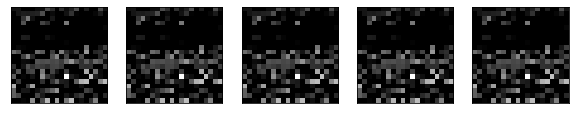

In [9]:
layer_visuals(2,training_data_results,1)

torch.Size([20, 120])
Base: 
12
Height: 
10


C:\Users\Andy Xie\Anaconda3\envs\api-dev\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


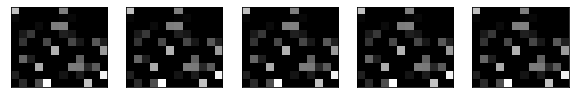

In [10]:
layer_visuals(3,testing_data_results,7)

In [11]:
def layer_loss_analysis(layer_num,data_results,loss_func):
    if data_results[2] == 'training':
        chosen_layer = data_results[0][layer_num]
        print(chosen_layer.shape)
        if len(chosen_layer.shape) == 2:
            layer = torch.nn.functional.log_softmax(chosen_layer, dim=1)
            loss = loss_func(layer, data_results[1])
            print('Layer Number: {}, Loss: {:.6f}\n'.format(layer_num, loss)) 
        else:
            print('Invalid')
    if data_results[2] == 'testing':
        chosen_layer = data_results[0][layer_num]
        print(chosen_layer.shape)
        if len(chosen_layer.shape) == 2:
            layer = torch.nn.functional.log_softmax(chosen_layer, dim=1)
            loss = loss_func(layer, data_results[1])
            print('Layer Number: {}, Loss: {:.6f}\n'.format(layer_num, loss))
        else:
            print('Invalid')

In [12]:
layer_loss_analysis(1,training_data_results,loss_function)

torch.Size([20, 6, 14, 14])
Invalid


In [13]:
layer_loss_analysis(0,testing_data_results,loss_function)

torch.Size([20, 10])
Layer Number: 0, Loss: 1.489610



In [14]:
def accuracy_individual_classes(classes,test_set):
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    for data in test_set:
        images, labels = data
        outputs = network(images)
        _, predicted = torch.max(outputs[0], 1)
        correct = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    for i in range(len(classes)):
        print('Accuracy of %s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [30]:
accuracy_individual_classes(classes,test_load)

Accuracy of plane : 63 %
Accuracy of car : 64 %
Accuracy of bird : 22 %
Accuracy of cat : 56 %
Accuracy of deer : 50 %
Accuracy of dog : 17 %
Accuracy of frog : 62 %
Accuracy of horse : 39 %
Accuracy of ship : 45 %
Accuracy of truck : 47 %


In [ ]:
def saving_textfile(file,pandas_true):
    filename = input('Enter filename: \n')
    directory = input('Enter a directory: \n')
    if pandas_true == False:
        f = open(str(directory)+'\\'+str(filename),'w+')
        for line in file:
            f.writelines(str(list(line.numpy())))
        f.close()
    else:
        file.to_csv(str(directory)+'\\'+str(filename),'w+')

In [29]:
def weights_biases():
    parameters = {}
    for i in network.named_parameters():
        parameters[i[0]] = i[1] 
    specific_parameters = parameters.keys()
    while(True):
        print('The weights and biases of these layers have been identified: \n')
        for j in specific_parameters:
            print(j)
        print('\n')
        wanted_parameter = input('Please enter the wanted parameter or enter 0 to exit. Press E to export a specific parameter. \n')
        print('\n')
        if wanted_parameter == '0':
            break
        elif wanted_parameter == 'E' or wanted_parameter == 'e':
            wanted_parameter = input('Please enter the parameter to export: \n')
            data = parameters[str(wanted_parameter)].detach()
            saving_textfile(data,False)
            break
        elif wanted_parameter[-4:] == 'bias':
            while(True):
                ith_bias_ith_layer, end = input('Enter the bias range: \n').split()
                if end == 'x':
                    break
                else:
                    print('\n')
                    print(parameters[wanted_parameter][int(ith_bias_ith_layer):int(end)].detach())
                    print('\n')
        else:
            ith_node = input('Enter the node number: \n')
            while(True):
                ith_weight_ith_node, end = input('Enter the input weights: \n').split()
                if end == 'x':
                    break
                else:
                    print('\n')
                    print(parameters[wanted_parameter][int(ith_node)][int(ith_weight_ith_node):int(end)].detach())
                    print('\n')
    print('Closed.')

In [30]:
weights_biases()

The weights and biases of these layers have been identified: 

conv1.weight
conv1.bias
conv2.weight
conv2.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias


Please enter the wanted parameter or enter 0 to exit. Press E to export a specific parameter. 
conv1.bias


Enter the bias range: 
1 3


tensor([-1.0199, -0.4302])


Enter the bias range: 
1 5


tensor([-1.0199, -0.4302, -0.3091, -0.1452])


Enter the bias range: 
0 x
The weights and biases of these layers have been identified: 

conv1.weight
conv1.bias
conv2.weight
conv2.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias


Please enter the wanted parameter or enter 0 to exit. Press E to export a specific parameter. 
conv2.weight


Enter the node number: 
4
Enter the input weights: 
2 23


tensor([[[-0.2096, -0.2332, -0.2076, -0.2103, -0.2525],
         [-0.1411, -0.1474, -0.1918, -0.2075, -0.1636],
         [-0.1299, -0.1867, -0.1604, -0.0901, -0.0199],
         [ 0.0155, -0.0566, -0.2150, -0.0504,  0